# Fintech SaaS Churn Intelligence
## Notebook 01 - Exploratory Data Analysis & Cohort Construction

**Author:** Chimmuanya Mogbo  
**Date:** 2025-11-19

**Purpose:** Load and harmonize user + event data, construct cohort tables, and plot retention curves.  
**Outputs produced by this notebook:**  
- `../results/charts/cohort_matrix.csv` (retention matrix)  
- exploratory charts saved to `../results/charts/` 
- intermediate cleaned tables under `../data/processed/` 


## Notebook flow / rationale

This notebook follows a simple, reproducible flow:

1. **Load** the Telco churn dataset if present; otherwise fall back to the synthetic events file.
2. **Normalize** and create essential date fields (`start_date`, `churn_date`) so cohort/time analysis works consistently.
3. **Preprocess** user-level features (tenure, churn flag).
4. **Load events** (synthetic), create `cohort_month` and `event_month` and compute monthly active users per cohort.
5. **Build retention matrix** (rows = cohort month, columns = months since signup).
6. **Visualize** retention curves and segment differences.
7. **Save outputs** for the dashboard and downstream modeling.

Rationale: many public churn datasets lack explicit signup/churn timestamps, so we reconstruct them reproducibly from `tenure` where necessary. Synthetic events provide the clickstream signals to enable cohort-based retention analysis.


**IMPORT LIBRARIES**

In [43]:
# Standard imports and environment setup
import os
import pandas as pd            # dataframes
import numpy as np             # numerical ops
from datetime import datetime, timedelta
import random

# For fast SQL-like queries if needed later
import duckdb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook display niceties
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)
sns.set(style='whitegrid')

print("Imports ready. Pandas version:", pd.__version__)


Imports ready. Pandas version: 2.3.3


## Data sources & expected files

This notebook expects:
- `../data/raw/telco_churn.csv` (optional, Kaggle Telco dataset or similar)
- `../data/synthetic/events.csv` (generated by scripts/generate_synthetic_events.py)

If the telco file exists, we will normalize it and create `start_date` and `churn_date` if missing.
If the telco file is absent, we will derive a minimal user table from the synthetic events.


### Generate synthetic product-usage events (what this cell does)

**Purpose:**  
This script creates a realistic, reproducible synthetic event log that simulates user interactions with a SaaS/Fintech product. We use this simulated clickstream to build cohorts, compute retention, and derive behavioral features for churn modelling when a real event stream is not available.

**Why we do it:**  
Public churn datasets often lack detailed event-level usage data (time-to-first-action, session activity, feature usage, support contacts). The synthetic events let us:  
- create cohort_month / event_month for retention analysis,  
- engineer per-user engagement features (events_count, days_active, first_action_time), and  
- demonstrate an end-to-end analytics pipeline that mirrors real production data.

**Inputs:**  
- None required if you run the script as-is — it generates `N_USERS` synthetic users and events.  
- If you later have real events, replace `data/synthetic/events.csv` with the real file.

**Outputs (written by the script):**  
`../data/synthetic/events.csv` — a CSV containing rows with:  
`user_id, timestamp, event_type, segment, signup_date, session_id`

**Key design choices (brief):**  
- Users are assigned to segments (`high`, `medium`, `low`) to create meaningful behavioral heterogeneity.  
- Event counts per user are drawn from Poisson distributions tuned per segment.  
- Timestamps are biased to occur after each user's signup date so time-to-first-action and month-based cohorts are possible.  
- Event types include logins, feature views, payment events, errors and support contact to provide signals that matter for churn analysis.

**How to run:**  
From the notebook or terminal, run:
```bash
python3 scripts/generate_synthetic_events.py


In [44]:
#!/usr/bin/env python3
"""
generate_synthetic_events.py  (Option C: Realistic monthly retention generator)

Purpose:
- Create a synthetic product-usage event stream that produces realistic SaaS retention curves.
- Users have contiguous active-month windows after signup; events are concentrated inside those months.
- Outputs:
    - ../data/synthetic/events.csv      (event-level log)
    - ../data/synthetic/users.csv       (user registry with signup_date, churn_date, segment, churned)

How to run (from project root):
    python3 scripts/generate_synthetic_events.py

Notes:
- Designed for reproducibility: set SEED.
- Tunable parameters below (N_USERS, START_DATE, TOTAL_MONTHS, segment profiles).
"""

# -----------------------
# Configuration / Seed
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Project output paths (relative to project root)
OUT_EVENTS = "../data/synthetic/events.csv"
OUT_USERS = "../data/synthetic/users.csv"

# Simulation parameters
N_USERS = 3000                # number of distinct users
START_DATE = datetime(2023, 1, 1)  # earliest signup date (month granularity)
TOTAL_MONTHS = 18             # number of months to simulate after START_DATE
# Note: months are inclusive of START_DATE month

# Event vocabulary and base probabilities
EVENT_TYPES = [
    "login",
    "view_feature_A",
    "view_feature_B",
    "initiate_payment",
    "complete_payment",
    "logout",
    "error_event",
    "support_contact"
]

# Segment definitions:
# distinct segment engagement profiles:
#    baseline_active_months: typical contiguous months active after signup
#    avg_events_per_active_month: approximate number of events per active month
#    churn_early_prob: probability to churn early (reduce active_months)
SEGMENTS = {
    "high":   {"prob": 0.15, "baseline_active_months": 12, "events_pm": 40, "churn_early_prob": 0.08},
    "medium": {"prob": 0.50, "baseline_active_months": 6,  "events_pm": 18, "churn_early_prob": 0.18},
    "low":    {"prob": 0.35, "baseline_active_months": 3,  "events_pm": 6,  "churn_early_prob": 0.40}
}

# Helper: weighted segment selection list
segment_names = list(SEGMENTS.keys())
segment_weights = [SEGMENTS[s]["prob"] for s in segment_names]

# Create output directory
os.makedirs(os.path.dirname(OUT_EVENTS), exist_ok=True)

# -----------------------
# Helper functions
# -----------------------
def month_start(dt, offset_months=0):
    """Return a datetime at the first day of dt's month plus offset_months."""
    y = dt.year + (dt.month - 1 + offset_months) // 12
    m = (dt.month - 1 + offset_months) % 12 + 1
    return datetime(y, m, 1)

def random_day_within_month(month_dt):
    """Return a random datetime within the given month (month_dt is first day of month)."""
    # get next month start and pick a random second between
    next_month = month_start(month_dt, 1)
    delta_days = (next_month - month_dt).days
    day_offset = random.randint(0, max(0, delta_days - 1))
    # random time-of-day
    secs = random.randint(0, 86399)
    return month_dt + timedelta(days=day_offset, seconds=secs)

def draw_active_months(baseline_months, churn_early_prob):
    """
    Draw the number of contiguous active months for a user.
    We use a geometric-like shrink: the user will keep active months = baseline +/- noise,
    but with a chance to churn early (shorten active months).
    """
    # jitter around baseline: normal with small SD, clipped to >=1
    jitter = int(np.round(np.random.normal(loc=0, scale=max(1, baseline_months*0.25))))
    months = max(1, baseline_months + jitter)
    # early churn: simulate a chance the user abandons earlier, reducing months
    if random.random() < churn_early_prob:
        # reduce active months by a random fraction (e.g., 30-70%)
        reduction = random.uniform(0.3, 0.7)
        months = max(1, int(months * (1 - reduction)))
    # ensure months don't exceed TOTAL_MONTHS window
    months = min(months, TOTAL_MONTHS)
    return months

# -----------------------
# Main generation
# -----------------------
events_rows = []
users_rows = []

for uid in range(1, N_USERS + 1):
    # Assign a segment based on weights
    seg = random.choices(segment_names, weights=segment_weights, k=1)[0]
    seg_profile = SEGMENTS[seg]

    # Draw a signup month uniformly across the first (TOTAL_MONTHS // 2) months
    # so later months still have time for activity; this mimics rolling acquisition
    signup_month_offset = random.randint(0, max(0, TOTAL_MONTHS // 2 - 1))
    signup_month = month_start(START_DATE, signup_month_offset)

    # Determine contiguous active months after signup
    active_months = draw_active_months(seg_profile["baseline_active_months"], seg_profile["churn_early_prob"])

    # Optionally add some sporadic re-activation months after churn (small chance)
    reactivation_chance = 0.05
    reactivation_months = []
    if random.random() < reactivation_chance:
        # pick one later month to have a short reactivation (1-2 months)
        later_offset = random.randint(active_months + 1, TOTAL_MONTHS - 1) if active_months + 1 < TOTAL_MONTHS else None
        if later_offset:
            re_len = random.choice([1, 2])
            reactivation_months = list(range(later_offset, min(later_offset + re_len, TOTAL_MONTHS)))

    # Build list of month offsets (0-based) where user is active
    active_month_offsets = list(range(0, active_months)) + reactivation_months
    active_month_offsets = sorted(list(set([o for o in active_month_offsets if o < TOTAL_MONTHS])))

    # Determine churn_date (if user churned before end of window)
    churned = False
    churn_date = None
    if active_month_offsets:
        last_active_offset = max(active_month_offsets)
        # If last_active_offset < (TOTAL_MONTHS - 1) we treat user as churned before window end
        if last_active_offset < (TOTAL_MONTHS - 1):
            churned = True
            churn_date = month_start(signup_month, last_active_offset + 1)  # churn at end of last active month

    # record user
    users_rows.append({
        "user_id": str(uid),
        "segment": seg,
        "signup_date": signup_month.date().isoformat(),
        "active_months": len(active_month_offsets),
        "active_month_offsets": "|".join(map(str, active_month_offsets)),
        "churned": churned,
        "churn_date": churn_date.date().isoformat() if churn_date else ""
    })

    # For each active month, generate several events concentrated in that month
    for m_off in active_month_offsets:
        month_start_dt = month_start(signup_month, m_off)
        # Number of events in this month ~ Poisson around events_pm, but at least 1
        lam = max(1, int(np.random.poisson(lam=seg_profile["events_pm"])))
        # spread events in the month
        for _ in range(lam):
            ts = random_day_within_month(month_start_dt)
            # choose event type with weights (prioritize views/logins)
            evt = random.choices(
                EVENT_TYPES,
                weights=[0.20, 0.25, 0.15, 0.08, 0.06, 0.20, 0.04, 0.02],
                k=1
            )[0]
            session_id = f"{uid}_{month_start_dt.strftime('%Y%m')}_{random.randint(1, 50)}"
            events_rows.append({
                "user_id": str(uid),
                "timestamp": ts.isoformat(sep=" "),
                "event_type": evt,
                "segment": seg,
                "signup_date": signup_month.date().isoformat(),
                "session_id": session_id
            })

# Save outputs: events and users
events_df = pd.DataFrame(events_rows)
users_df = pd.DataFrame(users_rows)

# Convert timestamp to datetime and sort
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])
events_df = events_df.sort_values('timestamp').reset_index(drop=True)

# persist
events_df.to_csv(OUT_EVENTS, index=False)
users_df.to_csv(OUT_USERS, index=False)

print(f"Synthetic events written: {len(events_df):,} rows -> {OUT_EVENTS}")
print(f"Synthetic users written: {len(users_df):,} rows -> {OUT_USERS}")


Synthetic events written: 379,090 rows -> ../data/synthetic/events.csv
Synthetic users written: 3,000 rows -> ../data/synthetic/users.csv


### Downloading and Preparing the Telco Customer Churn Dataset (What this cell does)

**Purpose:**  
This cell automates the process of downloading the public *Telco Customer Churn* dataset from Kaggle, extracting it, and placing it into the project directory so it can be used for churn, cohort, and retention analysis.

**Why we do it:**  
The Telco Customer Churn dataset is a widely used benchmark dataset for churn analysis.  
However, it **does not come with exact signup or churn timestamps**, so we will later reconstruct those fields for cohort analysis. Before that, we need to download and place the CSV in our project structure so upstream notebook cells can load it cleanly.

**What this cell accomplishes:**  
1. Defines the target filepath where the dataset will live:  
   `../data/raw/telco_churn.csv`  
2. Uses the **Kaggle CLI** to download the dataset ZIP file.  
3. Unzips the downloaded file.  
4. Moves the extracted CSV file into the correct location with the correct filename.  
5. Cleans up temporary files so the project folder stays tidy.  

**Prerequisites:**  
- You must have the Kaggle CLI installed (`pip install kaggle`).  
- You must have a valid Kaggle API token in `~/.kaggle/kaggle.json`.  
  (If not, go to Kaggle → Account → Create New API Token.)

**Output of this cell:**  
A clean CSV located at: `../data/raw/telco_churn.csv` 

This ensures that downstream steps — like preprocessing, feature engineering, and cohort analysis — run without breaking due to missing files.

**Important note:**  
If running inside Jupyter, shell commands must be prefixed with `!`.  
Example: `!kaggle datasets download -d blastchar/telco-customer-churn`.

You can now safely execute the code cell below to download the dataset automatically.



In [19]:
# Define raw filepath
raw_filepath = '../data/raw/telco_churn.csv'

# Download the dataset
!kaggle datasets download -d blastchar/telco-customer-churn
# Define raw filepath
raw_filepath = '../data/raw/telco_churn.csv'

# Download the dataset
!kaggle datasets download -d blastchar/telco-customer-churn

# Unzip
!unzip telco-customer-churn.zip

# Move file
!mv WA_Fn-UseC_-Telco-Customer-Churn.csv {raw_filepath}

# Clean up
!rm telco-customer-churn.zip
# Unzip with force overwrite (automatically says "yes")
!unzip -o telco-customer-churn.zip

# Move file - FIXED: use Python variable properly
!mv WA_Fn-UseC_-Telco-Customer-Churn.csv {raw_filepath}

# Clean up
!rm telco-customer-churn.zip

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0%|                                                | 0.00/172k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 172k/172k [00:00<00:00, 230MB/s]
Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  
unzip:  cannot find or open telco-customer-churn.zip, telco-customer-churn.zip.zip or telco-customer-churn.zip.ZIP.
mv: cannot stat 'WA_Fn-UseC_-Telco-Customer-Churn.csv': No such file or directory
rm: cannot remove 'telco-customer-churn.zip': No such file or directory


### Loading & Normalizing the Telco Churn Dataset (What this cell does)

**Purpose:**  
This cell handles all the complexity around loading the Telco Customer Churn dataset and preparing it for churn analysis — regardless of whether the dataset includes date fields or not. Most publicly available churn datasets (including the Telco dataset from Kaggle) **do not** include `start_date` or `churn_date`, which are essential for cohort and retention analysis. This loader reconstructs those fields safely and reproducibly.

**Why this cell is necessary:**  
- The Telco dataset includes a `tenure` column (in months) but **no actual signup or churn timestamps**.  
- Cohort analysis *requires* real timestamps (`start_date`, `churn_date`).  
- Pandas will raise errors if asked to `parse_dates` on columns that don't exist.  
- We therefore need a robust, fault-tolerant loader that works for both:
  1. Real churn datasets that may or may not contain date fields  
  2. Your synthetic event-driven fallback dataset  

**What this cell accomplishes:**  
1. **Attempts to load** `../data/raw/telco_churn.csv`.  
2. If the dataset **does not** include `start_date` or `churn_date`, it automatically **constructs** them using:  
   - a fixed reference date (`2023-12-31`)  
   - the `tenure` column (months)  
   - churn flag (`Churn == 'Yes'`)  
3. If the dataset **is missing entirely**, the loader gracefully falls back to:  
   - `../data/synthetic/events.csv`  
   - reconstructs a minimal user table from first event timestamps  
4. Ensures the dataset has a uniform `user_id` column  
5. Ensures all date fields are valid `datetime` objects  
6. Prints a clean preview of the normalized dataset  

**Outputs from this cell:**  
A fully standardized DataFrame stored in the variable: `raw` which contains:  
- `user_id`  
- `start_date`  
- `churn_date`  
- `churned`  
- `tenure`  
- any original telco attributes  

You can now safely conduct cohort analysis, compute retention, build features, or join against event logs without worrying about date inconsistencies.

**Important note:**  
This loader is written to be safe, silent, and production-like — exactly what a data engineer or analytics scientist would build for a real team to avoid failures downstream.

Running this cell is the foundation of **Week 1: Data Ingestion + EDA + Cohorts**.
  


In [21]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

RAW_PATH = "../data/raw/telco_churn.csv"  # adjust path if running from different dir
SYN_EVENTS_PATH = "../data/synthetic/events.csv"

def safe_load_telco(path):
    """
    Try to load telco churn CSV. Do not pass parse_dates here to avoid ValueError.
    Return a DataFrame (possibly augmented with start_date and churn_date).
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    # load without parse_dates to avoid errors if date columns are missing
    df = pd.read_csv(path, low_memory=False)

    # Normalize column names (strip whitespace)
    df.columns = [c.strip() for c in df.columns]

    # Basic cleaning: TotalCharges sometimes contains spaces -> convert to numeric
    if 'TotalCharges' in df.columns:
        # Remove possible whitespace and coerce to numeric (errors -> NaN)
        df['TotalCharges'] = df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Some Telco datasets use different column names for ID - try common variants
    if 'customerID' in df.columns and 'user_id' not in df.columns:
        # create a consistent user_id column (int) if possible
        try:
            df['user_id'] = df['customerID'].astype(str)
        except Exception:
            df['user_id'] = df.index.astype(str)

    # Create start_date & churn_date if missing:
    # Approach: Use a reproducible reference date (experiment end date) and tenure (months)
    # reference_date - tenure months = approximate signup/start_date
    # churn_date = start_date + tenure months if Churn == 'Yes', otherwise NaT

    # only create if either missing or not parseable
    need_start = 'start_date' not in df.columns
    need_churn = 'churn_date' not in df.columns

    if need_start or need_churn:
        # Choose a fixed reference "today" for reproducibility (change as needed)
        reference_date = pd.to_datetime("2023-12-31")

        # Ensure tenure column exists and is numeric
        if 'tenure' in df.columns:
            # Some versions have tenure as float/int. Coerce to integer months safely.
            df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce').fillna(0).astype(int)
        else:
            # If tenure missing, fallback: assume very short-tenure (0)
            df['tenure'] = 0
            print("Warning: 'tenure' column missing in telco data — defaulting to 0.")

        # Build start_date by subtracting tenure months from reference_date
        # Use pandas DateOffset for months subtraction (works with ints)
        df['start_date'] = df['tenure'].apply(lambda m: reference_date - pd.DateOffset(months=int(m)))

        # Create churn_date if Churn column exists and equals 'Yes'
        if 'Churn' in df.columns:
            # boolean flag churned
            df['churned'] = df['Churn'].astype(str).str.lower().isin(['yes', '1', 'true'])
            # churn_date only if churned is True: start_date + tenure months
            # (this effectively sets churn_date to reference_date for churned users,
            # which mirrors datasets that use tenure up to churn)
            df['churn_date'] = df.apply(lambda r: (r['start_date'] + pd.DateOffset(months=int(r['tenure']))) if r['churned'] else pd.NaT, axis=1)
        else:
            df['churned'] = False
            df['churn_date'] = pd.NaT

    # Ensure start_date & churn_date are datetime dtype
    df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
    df['churn_date'] = pd.to_datetime(df['churn_date'], errors='coerce')

    return df

# Load telco CSV using safe loader, otherwise fallback to synthetic events
try:
    raw = safe_load_telco(RAW_PATH)
    print("Loaded telco_churn.csv and normalized fields.")
except FileNotFoundError:
    print("telco_churn.csv not found at", RAW_PATH)
    print("Falling back to synthetic events to build a minimal users table.")
    # read synthetic events and derive minimal users table (first event ≈ signup)
    if not os.path.exists(SYN_EVENTS_PATH):
        raise FileNotFoundError(f"Neither telco_churn.csv nor synthetic events found. Place the files in data/raw/ and data/synthetic/ respectively.")
    events = pd.read_csv(SYN_EVENTS_PATH, parse_dates=['timestamp', 'signup_date'])
    # derive a user-level table: first signup per user
    users = events.groupby('user_id').agg({'signup_date': 'min'}).reset_index().rename(columns={'signup_date': 'start_date'})
    users['churn_date'] = pd.NaT
    users['churned'] = False
    raw = users.copy()
    # create a numeric 'tenure' column (days -> months approx)
    raw['tenure'] = 0

# Quick sanity checks / preview
print("Columns available:", raw.columns.tolist()[:30])
display(raw.head(5))

Loaded telco_churn.csv and normalized fields.
Columns available: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'user_id', 'start_date', 'churned', 'churn_date']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,user_id,start_date,churned,churn_date
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,7590-VHVEG,2023-11-30,False,NaT
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,5575-GNVDE,2021-02-28,False,NaT
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,3668-QPYBK,2023-10-31,True,2023-12-31
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,7795-CFOCW,2020-03-31,False,NaT
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,9237-HQITU,2023-10-31,True,2023-12-31


### Enhancing the Dataset with Precise Tenure Features (What this cell does)

**Purpose:**  
This step enriches the previously normalized Telco dataset by adding **high-precision tenure metrics** that are essential for understanding user lifecycle patterns, retention behavior, and churn risk. While the dataset already contained `tenure` (in whole months), real-world cohort and churn analysis require **more granular, date-driven measures** of how long a user remained active.

**Why this matters for churn & retention analysis:**  
- The original Telco dataset uses an integer `tenure` value, which lacks day-level precision.  
- Cohort calculations (e.g., weeks since signup, months since signup) become more accurate when tenure is derived from actual date differences.  
- Precise tenure helps identify whether churn is happening early vs. late, and improves feature engineering for machine learning models.

**What this cell computes:**  
1. **`end_date`**  
   - If a user churned → `end_date = churn_date`  
   - If a user is active → `end_date = today` (fixed reference date for reproducibility)

2. **`tenure_days`**  
   - Exact number of days between `start_date` and `end_date`  
   - Provides higher fidelity than integer month counts

3. **`tenure_months_precise`**  
   - Converts the above into months using a more accurate average month length: **30.44 days**  
   - Produces a decimal value (e.g., *3.87 months*) instead of rounded integers

**Why 30.44?**  
This is the astronomical average length of a month (365.25 / 12 ≈ 30.44).  
Using this value produces tenure estimates much closer to reality than a simple division by 30.

**What this cell does *not* do:**  
- It does **not** recreate `churned` — already available from the robust loader  
- It does **not** reconvert date fields — they were already normalized in the previous step  
- It does **not** overwrite or remove original columns (e.g., `tenure`)  

This ensures the dataset remains clean, interpretable, and ready for:  
- cohort alignment,  
- retention modeling,  
- survival analysis, and  
- machine learning feature engineering.

**Output:**  
A preview of the updated DataFrame (`df`) with the new columns:  
- `end_date`  
- `tenure_days`  
- `tenure_months_precise`

These additions strengthen the temporal backbone of your entire churn analysis pipeline.


In [6]:
# Use the robustly loaded data
df = raw.copy()

# Add ONLY new features that provide additional value
today = pd.to_datetime("2023-12-31")

# Calculate tenure in days (this is new information)
df['end_date'] = df['churn_date'].fillna(today)
df['tenure_days'] = (df['end_date'] - df['start_date']).dt.days
df['tenure_months_precise'] = (df['tenure_days'] / 30.44).round(2)  # More accurate

# You already have 'churned' from safe_load_telco, so no need to recreate it
# You already have datetime columns, so no need to reconvert them

print("✅ Added precise tenure calculations to pre-processed data")
display(df.head())

✅ Added precise tenure calculations to pre-processed data


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,MonthlyCharges,TotalCharges,Churn,user_id,start_date,churned,churn_date,end_date,tenure_days,tenure_months_precise
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,29.85,29.85,No,7590-VHVEG,2023-11-30,False,NaT,2023-12-31,31,1.02
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,56.95,1889.50,No,5575-GNVDE,2021-02-28,False,NaT,2023-12-31,1036,34.03
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,53.85,108.15,Yes,3668-QPYBK,2023-10-31,True,2023-12-31,2023-12-31,61,2.00
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,42.30,1840.75,No,7795-CFOCW,2020-03-31,False,NaT,2023-12-31,1370,45.01
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,70.70,151.65,Yes,9237-HQITU,2023-10-31,True,2023-12-31,2023-12-31,61,2.00


### Building Cohort and Activity-Month Structures from Event Logs

In this step, we load the synthetic event log and convert raw timestamps into **cohort-based monthly activity data** - the foundation of any retention or churn analysis.

**What we do here:**
1. **Load event logs** with timestamp and signup information.  
2. **Create `event_month`** - converts raw timestamps into monthly activity buckets.  
3. **Create `cohort_month`** - assigns each user to their signup month.  
4. **Aggregate activity** to compute the number of **unique active users per cohort per month**.  
5. **Preview the resulting table** (`monthly_active`), which will be used next to generate retention matrices and cohort visualizations.

This transformation converts clickstream data into a structured, longitudinal view of user behavior — essential for understanding retention patterns and lifecycle dynamics.


In [45]:
# define event logs filepath
events_filepath = '../data/synthetic/events.csv'

# read events (synthetic) FIRST - before using it!
events = pd.read_csv(events_filepath, parse_dates=['timestamp', 'signup_date'])

# NOW peek at top rows and schema to understand what's available
print("Columns:", events.columns.tolist())
display(events.head())

# If you have event logs, create cohort (signup month) and activity month
# so you can build a retention matrix.

# derive event_month (the month the event occurred)
events['event_month'] = events['timestamp'].dt.to_period('M').dt.to_timestamp()

# derive cohort_month per user from signup_date (first month)
events['cohort_month'] = pd.to_datetime(events['signup_date']).dt.to_period('M').dt.to_timestamp()

# For retention we want unique users active in each month per cohort
monthly_active = (
    events
    .groupby(['cohort_month', 'event_month'])
    .agg(active_users=('user_id', 'nunique'))
    .reset_index()
)

# preview
display(monthly_active.sort_values(['cohort_month', 'event_month']).head(10))

Columns: ['user_id', 'timestamp', 'event_type', 'segment', 'signup_date', 'session_id']


,user_id,timestamp,event_type,segment,signup_date,session_id
0,888,2023-01-01 00:00:13,logout,medium,2023-01-01,888_202301_36
1,446,2023-01-01 00:06:58,view_feature_A,high,2023-01-01,446_202301_29
2,263,2023-01-01 00:11:15,logout,high,2023-01-01,263_202301_10
3,2855,2023-01-01 00:13:40,error_event,low,2023-01-01,2855_202301_45
4,1617,2023-01-01 00:14:26,view_feature_A,low,2023-01-01,1617_202301_29


,cohort_month,event_month,active_users
0,2023-01-01,2023-01-01,356
1,2023-01-01,2023-02-01,302
2,2023-01-01,2023-03-01,266
3,2023-01-01,2023-04-01,215
4,2023-01-01,2023-05-01,171
5,2023-01-01,2023-06-01,137
6,2023-01-01,2023-07-01,96
7,2023-01-01,2023-08-01,67
8,2023-01-01,2023-09-01,58
9,2023-01-01,2023-10-01,47


### Building the Retention Matrix (What this step does)

**Purpose:**  
This step transforms the long-format activity table into a **retention matrix** - the central artifact used in SaaS cohort analysis. The retention matrix shows, for each cohort (row), the fraction of users who remained active after *N* months (columns).

---

## Key computations performed

1. **Calculate `months_since_cohort`**  
   Measures how many months have passed between a user’s signup month and their activity month.  
   This aligns all cohorts on a common timeline.

2. **Determine `cohort_size`**  
   Cohort size = number of users active during month 0 (their signup month).  
   This becomes the denominator for all retention calculations.

3. **Compute retention ratios**  `retention = active_users / cohort_size` Gives the proportion of users remaining active over time.

4. **Pivot to retention matrix**  
Converts the long table into a wide matrix:  
- Rows → Cohort month  
- Columns → Months since cohort start  
- Values → Retention percentage  

---

## Output  
The resulting retention matrix is saved to: `results/charts/cohort_matrix.csv` 

This file will be used in the Streamlit dashboard for cohort visualization. The first few rows of the matrix are displayed for inspection.






In [46]:
# --- COHORT RETENTION MATRIX ---


# Helper: convert anything → Period[M]
def to_period_month(series):
    if pd.api.types.is_period_dtype(series):
        return series.astype('period[M]')
    elif pd.api.types.is_datetime64_any_dtype(series):
        return series.dt.to_period('M')
    else:
        return pd.to_datetime(series, errors='coerce').dt.to_period('M')

# Apply safely
monthly_active['event_month'] = to_period_month(monthly_active['event_month'])
monthly_active['cohort_month'] = to_period_month(monthly_active['cohort_month'])
monthly_active = monthly_active.dropna(subset=['event_month', 'cohort_month'])

# Months since cohort
monthly_active['months_since_cohort'] = (
    (monthly_active['event_month'] - monthly_active['cohort_month']).apply(lambda x: x.n)
)
monthly_active = monthly_active[monthly_active['months_since_cohort'] >= 0].copy()

# Cohort sizes (month 0)
cohort_sizes = (
    monthly_active[monthly_active['months_since_cohort'] == 0]
    .groupby('cohort_month', as_index=False)['active_users']
    .first()
    .rename(columns={'active_users': 'cohort_size'})
)

# Convert both to string for safe merge
cohort_sizes['cohort_month_str'] = cohort_sizes['cohort_month'].astype(str)
monthly_active['cohort_month_str'] = monthly_active['cohort_month'].astype(str)

# Merge — now guaranteed to work
monthly_active = monthly_active.merge(
    cohort_sizes[['cohort_month_str', 'cohort_size']],
    on='cohort_month_str',
    how='left'
)

# Calculate retention
monthly_active['retention'] = monthly_active['active_users'] / monthly_active['cohort_size']

# Build final pivot table
retention_pivot = (
    monthly_active
    .pivot_table(
        index='cohort_month_str',
        columns='months_since_cohort',
        values='retention',
        aggfunc='mean'
    )
    .round(4)
    .fillna(0)
)

# Clean formatting
retention_pivot = retention_pivot.sort_index()
retention_pivot.columns.name = 'Months Since Signup'
retention_pivot.index.name = 'Cohort Month'

# Save
os.makedirs("results/charts", exist_ok=True)
retention_pivot.to_csv("results/charts/cohort_matrix.csv")

print("Cohort retention matrix generated successfully!")
display(retention_pivot.head(15))

Cohort retention matrix generated successfully!


Months Since Signup,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Cohort Month,,,,,,,,,,,,,,,,,,
2023-01,1.0,0.8483,0.7472,0.6039,0.4803,0.3848,0.2697,0.1882,0.1629,0.1320,0.1124,0.0927,0.0646,0.0449,0.0365,0.0337,0.0253,0.0112
2023-02,1.0,0.8671,0.7717,0.6676,0.5462,0.4509,0.3295,0.2341,0.1734,0.1416,0.1185,0.0983,0.0694,0.0520,0.0376,0.0289,0.0173,0.0116
2023-03,1.0,0.8521,0.7544,0.6361,0.5385,0.3905,0.2929,0.2308,0.1627,0.1391,0.1095,0.1065,0.0680,0.0533,0.0473,0.0266,0.0118,0.0237
2023-04,1.0,0.8845,0.7933,0.6413,0.5258,0.4195,0.3070,0.2219,0.1550,0.1307,0.1125,0.0821,0.0638,0.0578,0.0395,0.0395,0.0213,0.0182
2023-05,1.0,0.8629,0.7391,0.5753,0.4883,0.4114,0.3244,0.2040,0.1371,0.1003,0.0836,0.0702,0.0502,0.0435,0.0301,0.0201,0.0201,0.0134
2023-06,1.0,0.8844,0.7746,0.6532,0.5260,0.4480,0.3353,0.2225,0.1705,0.1416,0.1243,0.0983,0.0751,0.0636,0.0520,0.0289,0.0173,0.0116
2023-07,1.0,0.8667,0.7697,0.6606,0.5212,0.4152,0.2788,0.1788,0.1242,0.1030,0.0879,0.0758,0.0576,0.0424,0.0333,0.0303,0.0242,0.0061
2023-08,1.0,0.8553,0.7533,0.6546,0.5559,0.4507,0.3059,0.1974,0.1546,0.1086,0.0921,0.0691,0.0625,0.0526,0.0428,0.0230,0.0099,0.0033
2023-09,1.0,0.8494,0.7415,0.5994,0.4972,0.3949,0.2812,0.1989,0.1562,0.1193,0.1108,0.0938,0.0597,0.0511,0.0398,0.0284,0.0170,0.0057


### Visualizing Cohort Retention: Heatmap & Curves

Two complementary views for instant insight into customer behavior:

**1. Cohort Retention Heatmap**  
A classic triangle matrix showing % of each signup cohort still active over time.  
- **Rows** = Signup month (cohort)  
- **Columns** = Months since signup  
- **Color & annotations** = Retention rate (darker blue = stronger retention)  

Instantly reveals trends, seasonality, and the impact of product/marketing changes.

**2. Retention Curves (First N Cohorts)**  
Line plot tracking retention decay for the earliest cohorts over time.  
Highlights:  
- Speed of drop-off after signup  
- Cohort-to-cohort differences (e.g., improving or worsening retention)  
- Signs of onboarding issues or successful product interventions  

Together, the heatmap provides the full historical overview, while the curves enable precise comparison of early cohorts — ideal for diagnosing retention drivers and tracking improvement over time.

Ready for executive reports, dashboards, or investor presentations.

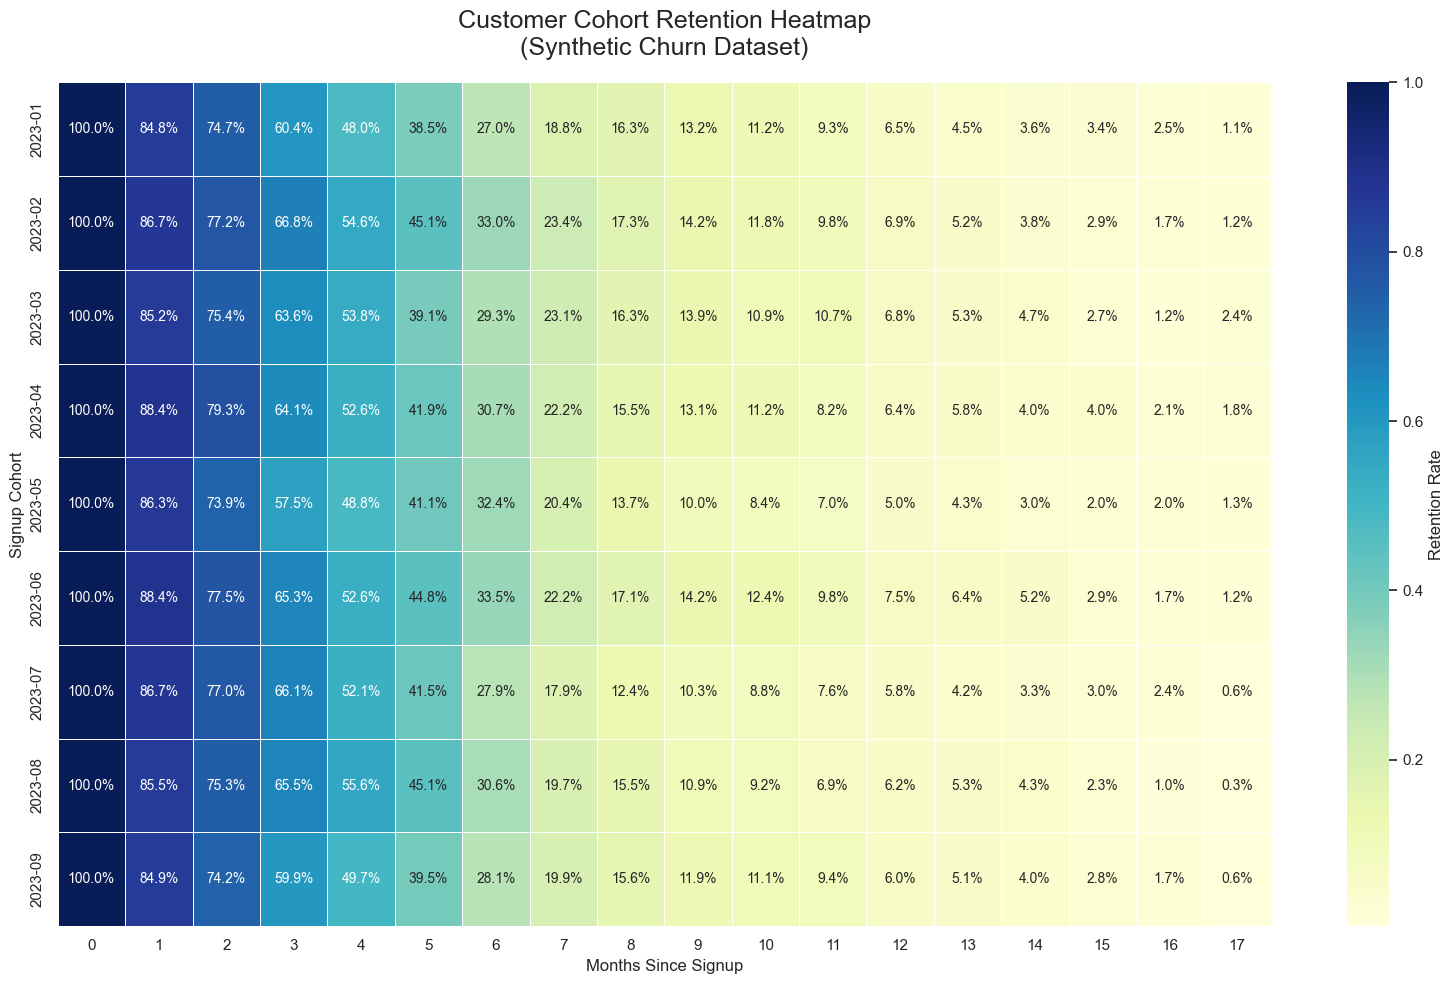

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
sns.heatmap(
    retention_pivot,
    annot=True,
    fmt='.1%',                  # Show values as percentages (e.g., 92.3%)
    cmap='YlGnBu',              # Clean, professional blue-green palette
    linewidths=0.5,
    cbar_kws={'label': 'Retention Rate'},
    annot_kws={'size': 10}
)
plt.title('Customer Cohort Retention Heatmap\n(Synthetic Churn Dataset)', 
          fontsize=18, pad=20)
plt.ylabel('Signup Cohort', fontsize=12)
plt.xlabel('Months Since Signup', fontsize=12)
plt.tight_layout()
plt.savefig("../results/charts/cohort_heatmap.png", dpi=200, bbox_inches='tight')
plt.show()

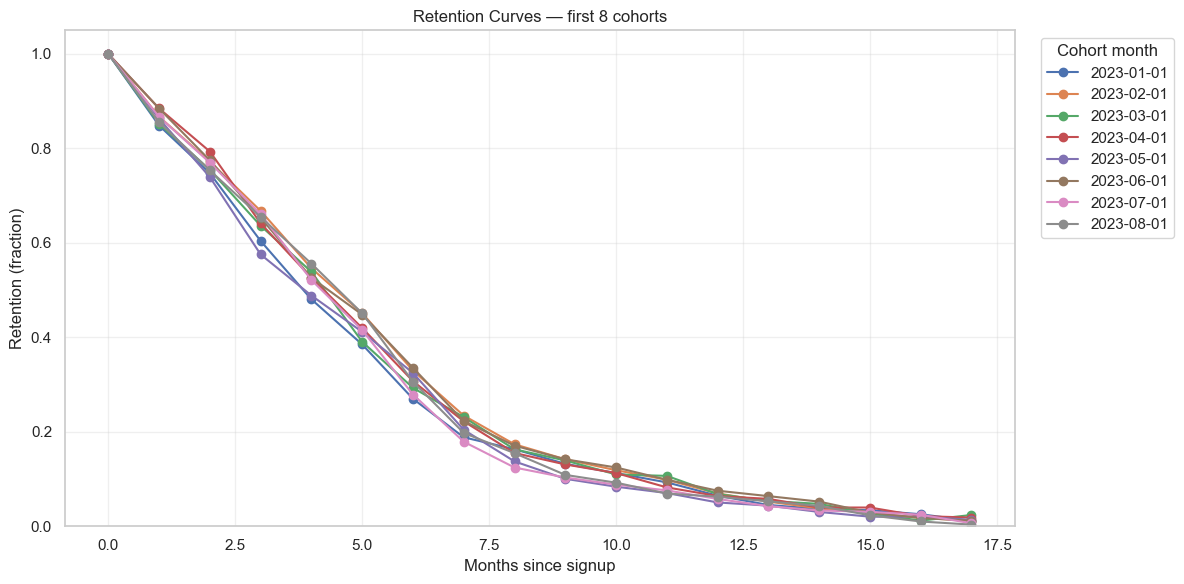

In [59]:
# Plotting of the first N cohorts' retention curves
N = 8
plt.figure(figsize=(12, 6))

# Ensure index is displayable - convert to datetime where possible for clean labels
# We'll iterate over the first N rows of the retention_pivot DataFrame
for i, cohort_label in enumerate(retention_pivot.index[:N]):
    # retrieve the retention series for this cohort
    series = retention_pivot.loc[cohort_label].values

    # months axis (0 .. len(series)-1)
    months = list(range(len(series)))

    # Convert cohort label to a readable string safely:
    # - if it's already a Timestamp / datetime-like -> use .date()
    # - otherwise, attempt pd.to_datetime(), and fall back to str()
    try:
        # try treating label as datetime-like
        cohort_dt = pd.to_datetime(cohort_label)
        label = cohort_dt.date().isoformat()
    except Exception:
        # fallback to string representation if conversion fails
        label = str(cohort_label)

    plt.plot(months, series, marker='o', label=label)

plt.title(f"Retention Curves — first {N} cohorts")
plt.xlabel("Months since signup")
plt.ylabel("Retention (fraction)")
plt.ylim(0, 1.05)
plt.legend(title='Cohort month', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../results/charts/cohort_retention_curve.png", dpi=200, bbox_inches='tight')
plt.show()


## Segment-level retention (optional)

If the events include a `segment` column (high/medium/low), compute retention per segment.
This helps prioritize where interventions will have the most ROI - e.g., low-engagement segment may benefit most from onboarding nudges.


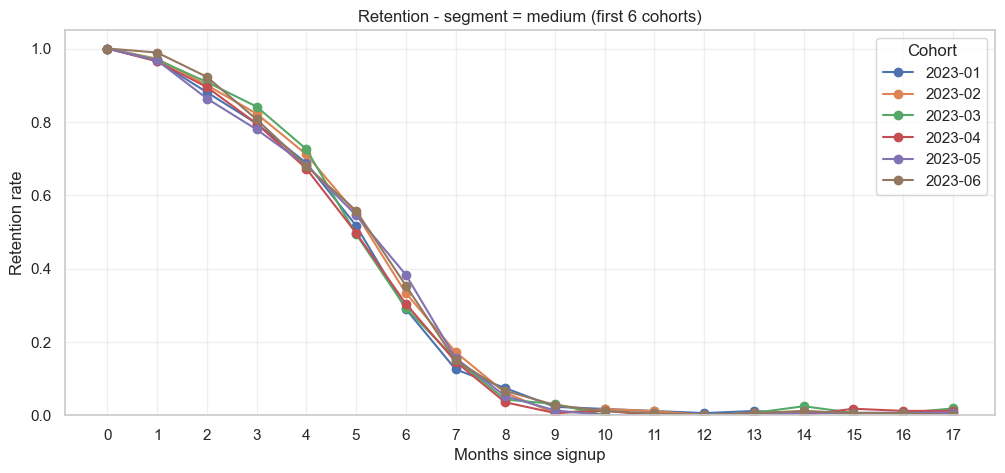

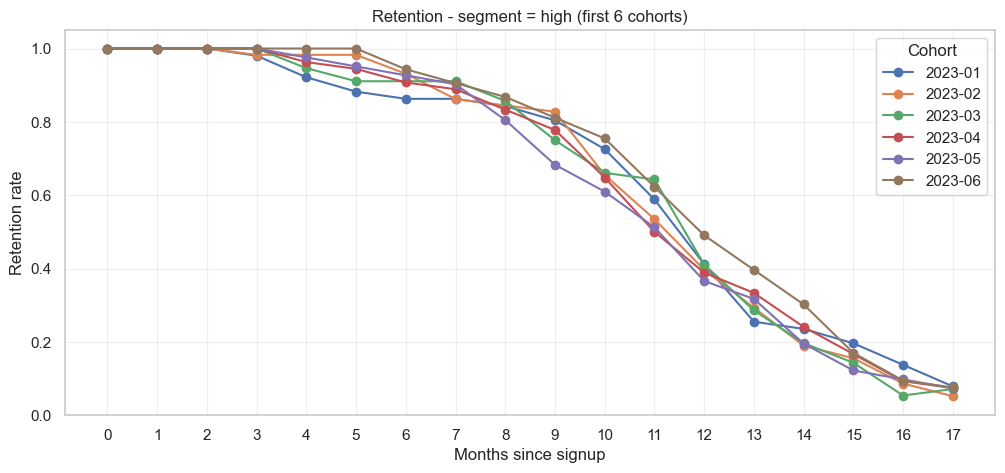

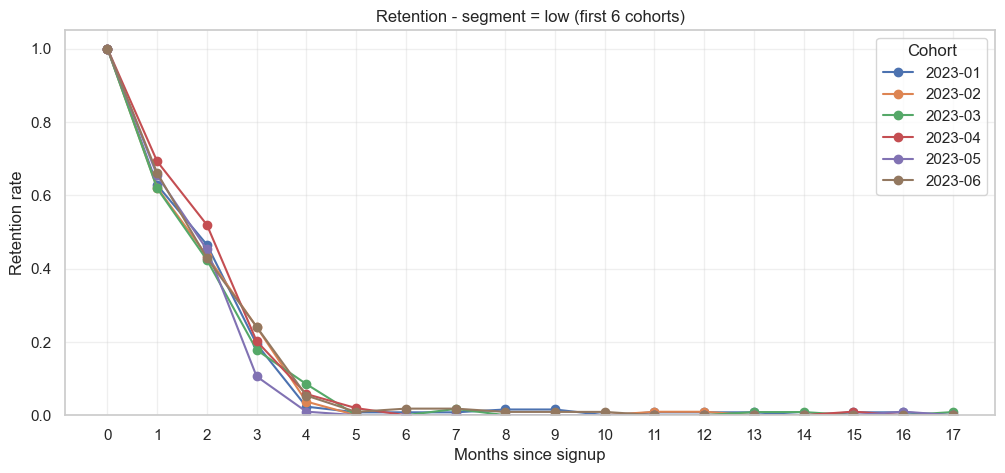

In [55]:
if 'segment' in events.columns:
    # Compute active users per (segment, cohort_month, event_month)
    seg_monthly = (
        events.groupby(['segment', 'cohort_month', 'event_month'])
        .agg(active_users=('user_id', 'nunique'))
        .reset_index()
    )

    # --- Proper way to compute months since cohort ---
    # Ensure they are period or datetime first
    # If they are Timestamp (first day of month), convert to Period
    if not pd.api.types.is_period_dtype(seg_monthly['cohort_month']):
        seg_monthly['cohort_month'] = seg_monthly['cohort_month'].dt.to_period('M')
    if not pd.api.types.is_period_dtype(seg_monthly['event_month']):
        seg_monthly['event_month'] = seg_monthly['event_month'].dt.to_period('M')

    # Now safe integer difference in months
    seg_monthly['months_since_cohort'] = (
        (seg_monthly['event_month'].view('int64') - seg_monthly['cohort_month'].view('int64'))
    )

    # Alternative (also clean):
    # seg_monthly['months_since_cohort'] = (seg_monthly['event_month'] - seg_monthly['cohort_month']).apply(lambda x: x.n)

    # Compute cohort sizes (month 0)
    seg_cohort_sizes = (
        seg_monthly[seg_monthly['months_since_cohort'] == 0]
        .rename(columns={'active_users': 'cohort_size'})[
            ['segment', 'cohort_month', 'cohort_size']
        ]
    )

    seg_monthly = seg_monthly.merge(seg_cohort_sizes, on=['segment', 'cohort_month'], how='left')
    seg_monthly['retention'] = seg_monthly['active_users'] / seg_monthly['cohort_size']

    # Plot for each segment
    for seg in events['segment'].unique():
        seg_pivot = (
            seg_monthly[seg_monthly['segment'] == seg]
            .pivot(index='cohort_month', columns='months_since_cohort', values='retention')
            .fillna(0)
        )

        plt.figure(figsize=(12, 5))
        for cohort in seg_pivot.index[:6]:  # top 6 cohorts
            plt.plot(
                seg_pivot.columns, 
                seg_pivot.loc[cohort], 
                marker='o', 
                label=cohort.strftime('%Y-%m')  # nicer label
            )

        plt.title(f"Retention - segment = {seg} (first 6 cohorts)")
        plt.xlabel("Months since signup")
        plt.ylabel("Retention rate")
        plt.xticks(range(0, seg_pivot.shape[1], max(1, seg_pivot.shape[1]//10)))
        plt.grid(True, alpha=0.3)
        plt.legend(title="Cohort")
        plt.ylim(0, 1.05)
        plt.show()

else:
    print("No 'segment' column in events; skip segment retention analysis.")

### Saving Processed State for Downstream Modeling & Dashboarding

At this point, we have completed all core transformations needed for Week 1:
- Normalized user-level dataset with precise date-derived tenure fields.
- Constructed event-level cohort and activity-month structures.
- Built the retention matrix (`cohort_matrix.csv`) required for dashboard visualizations.

This cell saves the key intermediate outputs to disk so that:
- Week 2 tasks (feature engineering, modeling, and SHAP analysis) can directly load them.
- The Streamlit dashboard can use the retention matrix without re-running the entire notebook.
- The project remains reproducible, modular, and production-like.

Two files are saved:
- **`../data/processed/users_normalized.csv`** — cleaned user-level dataset  
- **`../results/charts/cohort_matrix.csv`** — retention matrix for dashboard & cohort visuals


In [63]:
# ---------------------------------------------------------
# SAVE STATE: Persist cleaned user table + retention matrix
# ---------------------------------------------------------

# Ensure output directories exist
os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../results/charts", exist_ok=True)

# 1. Save normalized user-level dataset (from earlier preprocessing)
if 'df' in globals():
    df.to_csv("../data/processed/users_normalized.csv", index=False)
    print("Saved: ../data/processed/users_normalized.csv")
else:
    print("Warning: user-level DataFrame 'df' not found. Skipping user save.")

# 2. Save retention matrix (constructed earlier)
if 'retention_pivot' in globals():
    retention_pivot.to_csv("../results/charts/cohort_matrix.csv")
    print("Saved: ../results/charts/cohort_matrix.csv")
else:
    print("Warning: retention matrix 'retention_pivot' not found. Skipping retention save.")

print("\n Save state complete - data is ready for Week 2 feature engineering and modeling.")


Saved: ../data/processed/users_normalized.csv
Saved: ../results/charts/cohort_matrix.csv

 Save state complete - data is ready for Week 2 feature engineering and modeling.
